In [1]:
import pyxdf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

Load the data from the experimental input files for a single participant.

In [2]:
streams, header = pyxdf.load_xdf('./Path_Data/ID_100.xdf')
# for strm in streams:
#     print(f"Found stream {strm['info']['name'][0]} ({strm['info']['type'][0]}) with data shape "
#           f"{np.array(strm['time_series']).shape}")

stream_names = [strm['info']['name'][0] for strm in streams]
stream_types = [strm['info']['type'][0] for strm in streams]

In [3]:
data = {}

for stream in streams:
    stream_name = stream['info']['name'][0]
    stream_channels = {}
    for i, channels in enumerate(stream['info']['desc'][0]['channels'][0]['channel']):
        stream_channels[channels['label'][0]] = i
    stream_data = stream['time_series']
    
    #example of data layout
    #stream_name: LuminanceStream
    #stream_channels: {'UserID': 0, 'BlockID': 1, 'ModelID': 2, 'MethodID': 3, 'Luminance': 4}
    #stream_data: [[1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02][1.0000000e+02 0.0000000e+00 9.9000000e+01 9.9000000e+01 1.1425743e-02]
    data_dict= {}
    for key in stream_channels.keys():
        data_dict[key] = np.array(stream_data)[:, stream_channels[key]]
    time_stamps = np.array(stream['time_stamps'])
    for i in range(len(time_stamps)):
        time_stamps[i] = round(time_stamps[i], 4)
    data_dict['time'] = time_stamps
    data[stream_name] = data_dict



In [4]:
dfs = {}
for stream_name, stream_data in data.items():
    dfs[stream_name] = pd.DataFrame(stream_data)
    dfs[stream_name].drop_duplicates(subset=['time'], keep='first', inplace=True)
    dfs[stream_name].reset_index(drop=True, inplace=True)

In [5]:
gaze = dfs['GazeStream']
luminance = dfs['LuminanceStream']

pupil_calib_d = gaze.loc[(gaze['MethodID']>98.0) & (gaze['LeftEyeIsBlinking']==0) & (gaze['RightEyeIsBlinking']==0) & (gaze['LeftPupilDiameter']>0) & (gaze['RightPupilDiameter']>0), ['time', 'LeftPupilDiameter', 'RightPupilDiameter']]
pupil_calib_d.reset_index(drop=True, inplace=True)

lum_calib = luminance.loc[(luminance['MethodID']>98.0), ['time', 'Luminance']]
lum_calib.reset_index(drop=True, inplace=True)

gaze_luminance_time = np.intersect1d(pupil_calib_d['time'], lum_calib['time'])

pupil_calib_d = pupil_calib_d[pupil_calib_d['time'].isin(gaze_luminance_time)]
lum_calib = lum_calib[lum_calib['time'].isin(gaze_luminance_time)]
pupil_calib_d.reset_index(drop=True, inplace=True)
lum_calib.reset_index(drop=True, inplace=True)

In [6]:
#The predicted pupil dilation, d(Y), caused by the luminance Y was computed using the following equation:
#𝑑(𝑌) = 𝑎 · 𝑒^(−𝑏·𝑌) + c
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c


In [29]:
#create a single array from lum_calib['time'], pupil_calib_d['LeftPupilDiameter'], pupil_calib_d['RightPupilDiameter'], lum_calib['Luminance']
luminance_pupil_diameter = pd.DataFrame()
luminance_pupil_diameter['time'] = lum_calib['time']
luminance_pupil_diameter['Luminance'] = lum_calib['Luminance']
luminance_pupil_diameter['LeftPupilDiameter'] = pupil_calib_d['LeftPupilDiameter']
luminance_pupil_diameter['RightPupilDiameter'] = pupil_calib_d['RightPupilDiameter']
#print(luminance_pupil_diameter)
luminance_pupil_diameter.set_index('Luminance', inplace = True)
#print(luminance_pupil_diameter)
luminance_pupil_diameter.sort_index(inplace=True)
print(luminance_pupil_diameter)


                 time  LeftPupilDiameter  RightPupilDiameter
Luminance                                                   
0.000000   76535.2037           2.893082            2.664780
0.000000   76539.3235           5.143188            5.005020
0.000000   76539.1565           5.452744            5.088104
0.000000   76539.1455           5.368622            5.116898
0.000000   76539.1333           5.416656            5.104034
...               ...                ...                 ...
0.761598   76531.1496           2.781387            2.758011
0.761598   76531.1376           2.781128            2.769394
0.761598   76531.1277           2.795319            2.774780
0.761598   76531.2716           2.745865            2.712677
0.761598   76532.8594           2.820587            2.821014

[3443 rows x 3 columns]


In [91]:
#𝑎, 𝑏, and 𝑐 were fitted using least squares optimization with empirically determined bounds of a: [1, 4], b: [4, 8], and c: [0, 8]

popt_l, pcov_l = curve_fit(func, lum_calib['Luminance'], pupil_calib_d['LeftPupilDiameter'], bounds=([1, 4, 0], [4, 8, 8]))

luminance_pupil_diameter = pupil_calib_d.join(lum_calib['Luminance'], how='inner', on='time')
sorted_luminance = np.sort(luminance_pupil_diameter['Luminance'])
#popt_r, pcov_r = curve_fit(func, lum_calib['Luminance'], pupil_calib_d['RightPupilDiameter'], bounds=([1, 4, 0], [4, 8, 8]))

C:\Users\court\AppData\Local\Temp\ipykernel_12004\2745851080.py:5: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  luminance_pupil_diameter = pupil_calib_d.join(lum_calib['Luminance'], how='inner', on='time')


ValueError: x and y must have same first dimension, but have shapes (3443,) and (0,)

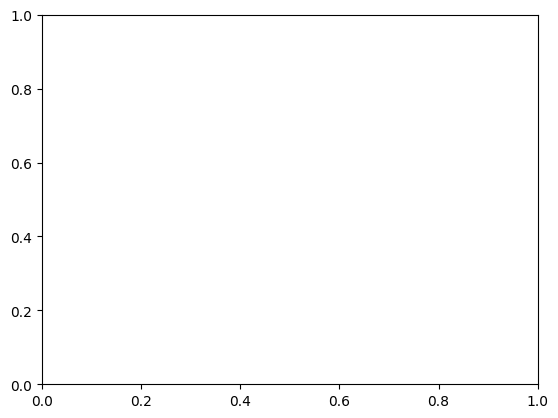

In [103]:
#plot popt_l and sorted_luminance[luminance] and pupil_diameter
fig, ax = plt.subplots()
#ax.scatter(sorted_luminance, func(sorted_luminance, *popt_l), label='Left Pupil Diameter')
#ax.plot(lum_calib['Luminance'], func(lum_calib['Luminance'], *popt_r), label='Right Pupil Diameter')
ax.plot(lum_calib['time'], func(sorted_luminance, *popt_l), label='Left Pupil Diameter')
ax.plot(lum_calib['time'], pupil_calib_d['LeftPupilDiameter'], label='Left Pupil Diameter')
#ax.scatter(lum_calib['Luminance'], pupil_calib_d['RightPupilDiameter'], label='Right Pupil Diameter')
ax.legend()
plt.show()

